In [4]:
import json
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import ternary
%matplotlib inline
import scipy

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [5]:
# Class to store each tag coordinate data
class tagClass:
    def __init__(self, data: dict, tClass, s: int):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip(s)
        self.tagClass = tClass
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    def getSnip(self, s=20):
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [6]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [7]:
def getTags(rawData, nType, s):
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n, s)
            listData.append(d)
    return listData

In [8]:
trainTags = getTags(raw15['0'], ['649', '655', '657', '659', '661'], 10)
testTags = getTags(raw15['0'], ['669', '671'], 10)

In [9]:
bayerFilter = [["R", "G"],
               ["G", "B"]]
# Find Bayer filter pixel colour for given coordinate
def getBayer(x, y):
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [10]:
def getSnipPlot(tag):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    plt.imshow(photo[tagY:tagY2,tagX:tagX2],cmap='gray')
    plt.colorbar()
    # rect = patches.Rectangle((tag.getY()-tagY-5, tag.getX()-tagX-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    plt.show()

    return photo

In [11]:
def getPhoto(tag: tagClass):
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [12]:
def getPixels(t, photo):
    tagX, tagX2, tagY, tagY2 = t
    colourPixels = [[], [], []] # R G B
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                colourPixels[0].append(photo[py, px])
            elif col == 'G':
                colourPixels[1].append(photo[py, px])
            else:
                colourPixels[2].append(photo[py, px])
    totalSum = sum(colourPixels[0]) + sum(colourPixels[1]) + sum(colourPixels[2])
    return sum(colourPixels[0])/totalSum, sum(colourPixels[1])/totalSum, sum(colourPixels[2])/totalSum

In [13]:
xTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in trainTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    xTags.loc[len(xTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

xTrain, xTest, yTrain, yTest = train_test_split(xTags[["Red", "Green", "Blue"]], xTags["Label"], test_size=0.2)

In [14]:
yTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in testTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    yTags.loc[len(yTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

In [15]:
allTags = pd.concat([xTags, yTags])

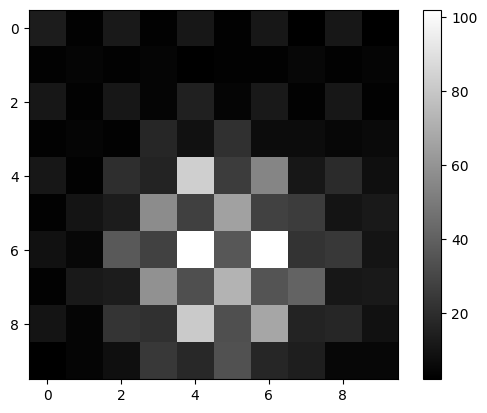

array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 6, 11,  6, ..., 13,  8, 12],
       [ 7,  6,  7, ...,  7,  8,  7],
       ...,
       [ 5,  8,  6, ...,  4,  5,  7],
       [ 6,  6,  7, ...,  6,  4,  5],
       [ 7,  6,  6, ...,  6,  5,  6]], dtype=uint8)

In [16]:
getSnipPlot(xTags["Tag"][0])

## Plot to RGB heatmap

In [17]:
def colorPoint(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

def plotHeatmap(asTuples, labels, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)#np.array(expected['002']))
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    plt.show()

In [18]:
scale = 30
# tagList = [0]
# sampleTags = allTags.loc[allTags["Label"].isin(tagList)]
# asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in sampleTags.iterrows()]
# labels = sampleTags["Label"]
# plotHeatmap(asTuples, labels, scale)

c:\Users\katie\AppData\Local\Programs\Python\Python311\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


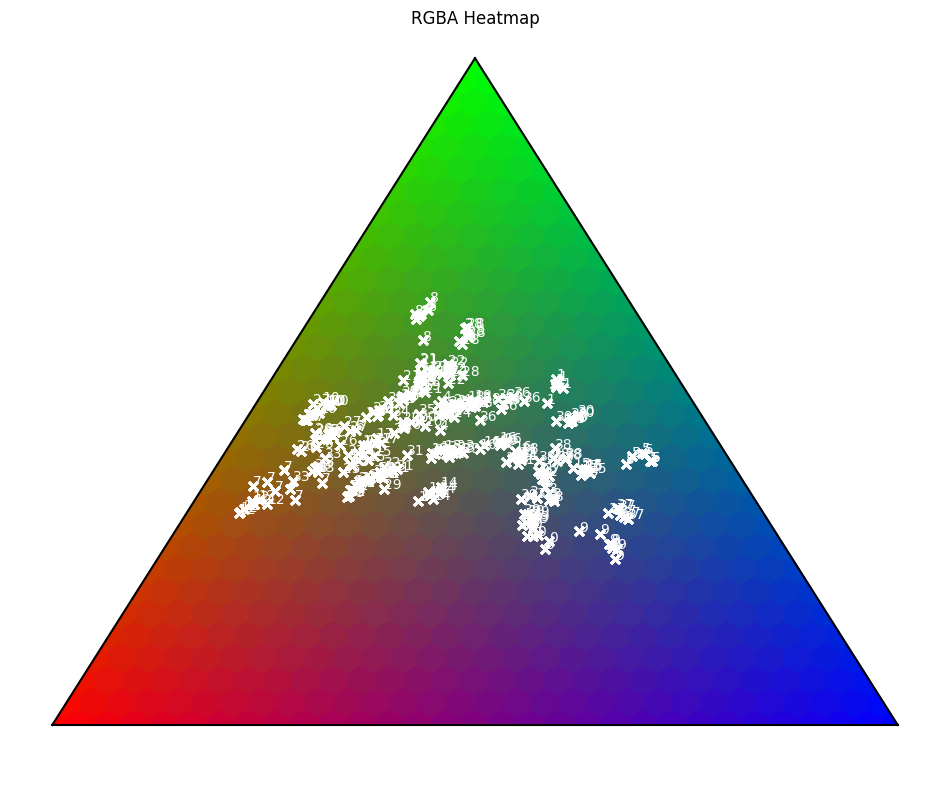

In [19]:
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in allTags.iterrows()]
labels = allTags["Label"]
plotHeatmap(asTuples, labels, scale)

## ML train/test

In [20]:
gnb = GaussianNB().fit(xTrain, yTrain)
gnbPred = gnb.predict(yTags[["Red", "Green", "Blue"]])

In [21]:
clf = svm.SVC().fit(xTrain, yTrain)
svmPred = clf.predict(yTags[["Red", "Green", "Blue"]])

In [22]:
# mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1).fit(xTrain, yTrain)
# mlpPred = mlp.predict(yTags[["Red", "Green"]])

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, name):
    print(name)
    print("Accuracy: ", accuracy_score(yTags["Label"], modelPred))
    print("F1: ", f1_score(yTags["Label"], modelPred, average='macro'))
    print("Precision: ", precision_score(yTags["Label"], modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(yTags["Label"], modelPred, average='macro'))
    print("MSE: ", mean_squared_error(yTags["Label"], modelPred), "\n")

In [24]:
scores(gnbPred, "GNB")
scores(svmPred, "SVM")
# scores(mlpPred, "MLP")

GNB
Accuracy:  0.6125
F1:  0.5844444444444444
Precision:  0.75578231292517
Recall:  0.6125
MSE:  92.75 

SVM
Accuracy:  0.35
F1:  0.22028860028860028
Precision:  0.46369047619047615
Recall:  0.35
MSE:  190.0625 



## Random notes

In [25]:
# average colours from all images - normalise
# R/(R+G+B) G/(R+G+B)
# train model on colours & labels
# test model to classfiy other image labels

# maybe remove background mesh
# func pixel coords generated to show brightness
# psf tagxy brightness pf col, bg of col, pixel ->> pred cixel col -> SSE
# brightness for each col -> then loop all pixels then predict pixels -> SSE = func - true picel val

In [26]:
# run with smaller box around pixels - brightest as centre?
# bokeh out of focus width affected by distance?
# estimate brightness of bg?
# estimate width of brightest tags
# hexagonal bokeh - find centre of bokeh
# px, py, bi, hi, xi, yi per picture but width is same
# x y is centre of bokeh - tag coords
# 
# sum ( fn(px py xi yi hi w) - true px py ) ^2 ) for each pixel -> fn = guess pixel value
# sum that for all pictures - see notebook!!

## Cost function

In [ ]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    if np.linalg.norm([pixelCoord, tagCoord]) < psfWidth:
        return tagBrightness+bgBrightness
    else:
        return bgBrightness

def simulate_img(trueImg, tagCoord, tagBright_r, tagBright_g, tagBright_b, bgBright_r, bgBright_g, bgBright_b, psfWidth):
    pixel_value_guesses = []
    # loop over pixel coords for each colour...
    for colour in range(3):
        if colour == 0:
            t, b = tagBright_r, bgBright_r
        elif colour == 1:
            t, b = tagBright_g, bgBright_g
        else:
            t, b = tagBright_b, bgBright_b

        for pixX in range(trueImg.shape[0]):
            for pixY in range(trueImg.shape[1]):
                # call simulate_pixel with the coords of the pixel and the appropriate element from the rgb vectors...etc
                pixel_value_guesses.append(simulate_pixel((pixX, pixY), tagCoord, t, b, psfWidth))
    return pixel_value_guesses


def cost_function(trueImg, tagCoord, tagBright_r, tagBright_g, tagBright_b, bgBright_r, bgBright_g, bgBright_b, psfWidth=5):
    pixel_value_guesses = simulate_img(trueImg, tagCoord, tagBright_r, tagBright_g, tagBright_b, bgBright_r, bgBright_g, bgBright_b, psfWidth)
    # sum square error over all the pxiels between the true image and the simulate_img
    square_error = [(s - a)**2 for (s, a) in zip(pixel_value_guesses, trueImg)]
    return sum(square_error)


scipy.optimize.minimize(cost_function, initial_parameters)

In [2]:
# photoTags = getTags(raw15['0'], ['649'], 10)
# photo = getPhoto(photoTags[0])
# coords = [(tag.getX(), tag.getY()) for tag in photoTags]
# red, green, blue = zip(*(getPixels(tag.getSnipCoords(), photo) for tag in photoTags))
# red_bg, green_bg, blue_bg = getPixels((0, photo.shape[1]-1, 0, photo.shape[0]-1), photo)



In [ ]:
# cost_function(photo, coords, red, green, blue, red_bg, green_bg, blue_bg)
# scipy.optimize.minimize(cost_function, , args=(photo, coords, red, green, blue, red_bg, green_bg, blue_bg))
# scipy.optimize.minimize(cost_function, initial_parameters)

# calculate proportion of pixel in circle?

In [ ]:
# def perPixel(photo, colour):
#     fn(p, t, b, h, 5) - pixelColour(p, photo)